In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapezoid
from scipy.interpolate import RectBivariateSpline  # type: ignore


# particula imports
from particula.next.dynamics.coagulation import brownian_kernel, rate
from particula.next.particles.properties.lognormal_size_distribution import (
    lognormal_pmf_distribution, lognormal_pdf_distribution
)
from particula.util.convert import distribution_convert_pdf_pms

## Create both a PDF and PMF


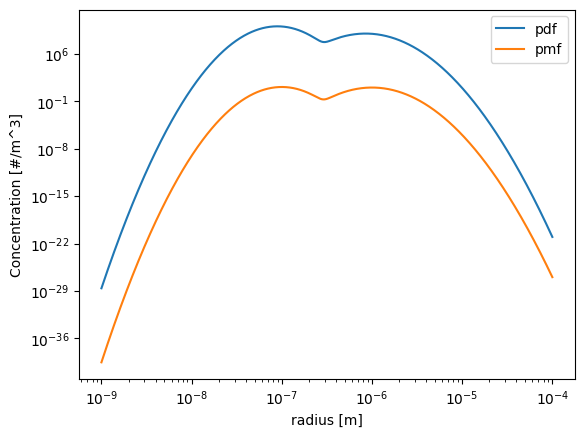

In [2]:
# Distribution parameters
mode = np.array([100e-9, 1e-6])
std = np.array([1.4, 1.5])
number = np.array([1e3, 1e3])
radius_bins = np.logspace(start=-9, stop=-4, num=1000)

# create the distribution
distribution_pdf = lognormal_pdf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=std,
    number_of_particles=number
)
distribution_pmf = lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=std,
    number_of_particles=number
)

# Plot the distribution
plt.figure()
plt.plot(radius_bins, distribution_pdf, label='pdf')
plt.plot(radius_bins, distribution_pmf, label='pmf')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

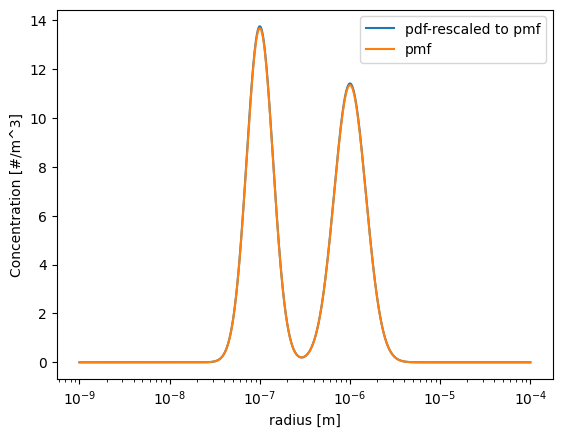

In [3]:
# rescale PDF to PMF
distribution_pdf_rescaled = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=distribution_pdf,
    to_pdf=False
)

# # Plot the distribution
plt.figure()
plt.plot(radius_bins, distribution_pdf_rescaled, label='pdf-rescaled to pmf')
plt.plot(radius_bins, distribution_pmf, label='pmf')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()


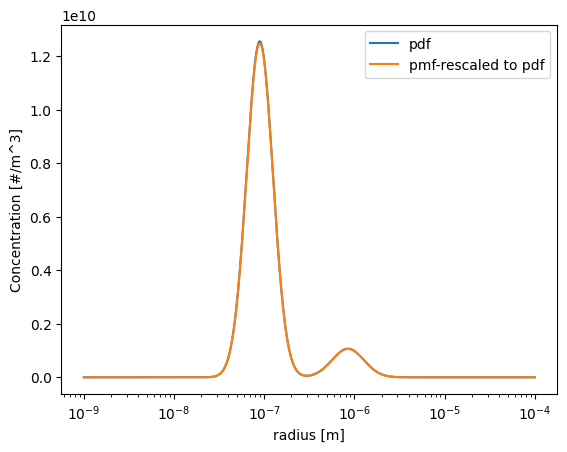

In [4]:
# pmf scaled to pdf
distribution_pmf_rescaled = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=distribution_pmf,
    to_pdf=True
)

plt.figure()
plt.plot(radius_bins, distribution_pdf, label='pdf')
plt.plot(radius_bins, distribution_pmf_rescaled, label='pmf-rescaled to pdf')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
plt.legend()
plt.show()

In [5]:
# Check number concentration PDF integration
number_concentration_pdf = trapezoid(distribution_pdf, x=radius_bins)
number_concentration_pmf_rescaled = trapezoid(distribution_pmf_rescaled, x=radius_bins)

print(f'Number concentration PDF: {number_concentration_pdf}')
print(f'Number concentration PMF rescaled to PDF: {number_concentration_pmf_rescaled}')

# Check number concentration PMF integration
number_concentration_pmf = distribution_pmf.sum()
number_concentration_pdf_rescaled = distribution_pdf_rescaled.sum()

print(f'Number concentration PMF: {number_concentration_pmf}')
print(f'Number concentration PDF rescaled to PMF: {number_concentration_pdf_rescaled}')

Number concentration PDF: 1999.9999999999995
Number concentration PMF rescaled to PDF: 1988.5417021919575
Number concentration PMF: 2000.0000000000002
Number concentration PDF rescaled to PMF: 2011.5243223669002


In [10]:
# Get the kernel
mass_bins = 4 / 3 * np.pi * radius_bins**3 * 1e3  # kg

kernel = brownian_kernel.brownian_coagulation_kernel_via_system_state(
    radius_particle=radius_bins,
    mass_particle=mass_bins,
    temperature=293.15,
    pressure=101325,
    alpha_collision_efficiency=1
)

# Coagulation rate PDF
concentration_0 = distribution_pdf
gain_pdf = rate.continuous_gain(
    radius=radius_bins,
    concentration=concentration_0,
    kernel=kernel,
)
loss_pdf = rate.continuous_loss(
    radius=radius_bins,
    concentration=concentration_0,
    kernel=kernel
)
net_pdf = gain_pdf - loss_pdf

# convert to volume distribution
gain_volume = gain_pdf * radius_bins * 4 / 3 * np.pi * radius_bins**3
loss_volume = loss_pdf * radius_bins * 4 / 3 * np.pi * radius_bins**3
net_volume = net_pdf * radius_bins * 4 / 3 * np.pi * radius_bins**3

# integrate the gain, loss and net
gain_total_volume = trapezoid(gain_volume, x=radius_bins)
loss_total_volume = trapezoid(loss_volume, x=radius_bins)
net_total_volume = trapezoid(net_volume, x=radius_bins)

print(f'Gain total volume: {gain_total_volume}')
print(f'Loss total volume: {loss_total_volume}')
print(f'Net total volume: {net_total_volume}')

Gain total volume: 1.2599926801612182e-31
Loss total volume: 1.24709127625806e-31
Net total volume: 1.2901403903158312e-33


In [11]:
# Coagulation rate PMF
concentration_0_pmf = distribution_pmf
gain_pmf = rate.discrete_gain(
    concentration=concentration_0_pmf,
    kernel=kernel,
)
loss_pmf = rate.discrete_loss(
    concentration=concentration_0_pmf,
    kernel=kernel
)
net_pmf = gain_pmf - loss_pmf

# convert to volume distribution
gain_volume_pmf = gain_pmf * radius_bins * 4 / 3 * np.pi * radius_bins**3
loss_volume_pmf = loss_pmf * radius_bins * 4 / 3 * np.pi * radius_bins**3
net_volume_pmf = net_pmf *radius_bins * 4 / 3 * np.pi * radius_bins**3

# sum the gain, loss and net
gain_total_volume_pmf = gain_volume_pmf.sum()
loss_total_volume_pmf = loss_volume_pmf.sum()
net_total_volume_pmf = net_volume_pmf.sum()

print(f'Gain total volume PMF: {gain_total_volume_pmf}')
print(f'Loss total volume PMF: {loss_total_volume_pmf}')
print(f'Net total volume PMF: {net_total_volume_pmf}')

Gain total volume PMF: 1.2927671727342777e-31
Loss total volume PMF: 1.2470912762580597e-31
Net total volume PMF: 4.567589647621732e-33


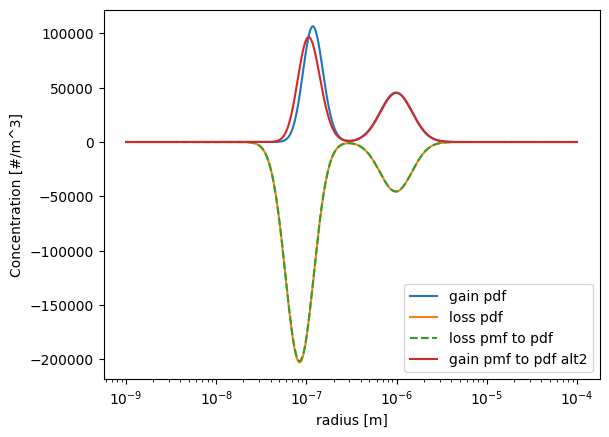

In [138]:
concentration = distribution_pmf / radius_bins
# coagulation gain
# 0.5 * sum to k-1, start j=1 of (C_k-1 * C_j * K_j,k-1)
# outer replaces, concentration * np.transpose([concentration])
gain_matrix = 0.5 * kernel * np.outer(concentration, concentration)

# select the diagonal to sum over, skip the first one, size as no particles
# will coagulate into it.
# rotate matrix
flipped_matrix = np.fliplr(gain_matrix)

# Generate offsets
offsets = len(flipped_matrix) - 1 - np.arange(len(flipped_matrix))

# Calculate traces of each diagonal
gain = np.array(
    [np.trace(flipped_matrix, offset=off) for off in offsets[:-1]]
)
# prepend the first element, as zero
gain_pmf = np.insert(gain, 0, 0)

# Initialize gain array
gain_pmf_loop = np.zeros(radius_bins.shape)

# Loop over each size bin k
for k in range(1, len(radius_bins)):
    # Initialize the sum for this bin
    gain_sum = 0.0

    # Sum over j from 1 to k-1
    for j in range(0, k):
        # Compute the contribution to the gain for this j
        gain_sum += concentration[k - j - 1] * concentration[j] * kernel[j, k - j]

    # Multiply by 0.5 and store in gain_pmf
    gain_pmf_loop[k] = 0.5 * gain_sum

# The first element remains zero since no particles can coagulate into the first bin
gain_pmf_loop[0] = 0

# outer replaces, concentration * np.transpose([concentration])
radius = radius_bins
interp = RectBivariateSpline(
    x=radius, y=radius, z=kernel * np.outer(concentration, concentration)
)

dpd = np.linspace(0, radius / 2 ** (1 / 3), radius.size)  # type: ignore
dpi = (np.transpose(radius) ** 3 - dpd**3) ** (1 / 3)


gain_pmf_alt = radius * np.sum(
    interp.ev(dpd, dpi)/radius, axis=0  # type: ignore
)


def CoagulationGainDiscrete2(radius_bins, kernel, concentration):
    # Number of bins
    N_bins = len(radius_bins)

    # Initialize the gain array
    gain = np.zeros(N_bins)

    # Loop over each bin for which we want to calculate the gain
    for k in range(N_bins):
        # Loop over possible j values for dpd and dpi
        for j in range(k):
            i = k - 1
            # Calculate the gain contribution for this pair (dpd, dpi)
            gain_contribution = (
                kernel[j, i] * concentration[j] * concentration[i]
            )

            # Sum the contributions for bin k
            gain[k] += gain_contribution

    return gain


# def CoagulationGainDiscrete(kernel, concentration):
#     # Number of bins
#     N_bins = len(concentration)

#     # Create the outer product of concentration with itself
#     concentration_outer = np.outer(concentration, concentration)

#     # Initialize the gain array
#     gain = np.zeros(N_bins)

#     # Loop over each bin for which we want to calculate the gain
#     for k in range(1, N_bins):  # Start from 1 since the first bin has no gain
#         # Use slicing and numpy summation to calculate the gain for each k
#         # Get the relevant slice of the kernel matrix
#         kernel_slice = kernel[:k, k - 1]

#         # Sum the contributions for bin k using matrix multiplication
#         gain[k] = np.sum(kernel_slice * concentration_outer[:k, k - 1])

#     return gain


def CoagulationGainDiscrete(kernel, concentration):
    # Number of bins
    N_bins = len(concentration)

    # Initialize the gain array
    gain = np.zeros(N_bins)

    # Compute the concentration outer product only once
    concentration_outer = np.outer(concentration, concentration)

    # Compute slices of the kernel and the concentration outer product
    for k in range(1, N_bins):
        gain[k] = np.dot(kernel[:k, k - 1], concentration_outer[:k, k - 1])

    return gain


gain_pmf_alt2 = CoagulationGainDiscrete(kernel, concentration)
gain_pmf_alt = CoagulationGainDiscrete2(radius_bins, kernel, concentration)

# Convert the PMF to PDF
gain_pmf_to_pdf = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=gain_pmf,
    to_pdf=True
)
loss_pmf_to_pdf = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=loss_pmf,
    to_pdf=True
)
net_pmf_to_pdf = gain_pmf_to_pdf - loss_pmf_to_pdf

gain_pmf_to_pdf_loop = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=gain_pmf_loop,
    to_pdf=True
)
gain_pmf_to_pdf_alt = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=gain_pmf_alt,
    to_pdf=True
)
gain_pmf_to_pdf_alt2 = distribution_convert_pdf_pms(
    x_array=radius_bins,
    distribution=gain_pmf_alt2,
    to_pdf=True
)

# plot the results
plt.figure()
plt.plot(radius_bins, gain_pdf*radius_bins, label='gain pdf')
plt.plot(radius_bins, -1*loss_pdf*radius_bins, label='loss pdf')
# plt.plot(radius_bins, net_pdf*radius_bins, label='net pdf')
# plt.plot(radius_bins, gain_pmf_to_pdf*radius_bins, label='gain pmf to pdf')
plt.plot(radius_bins, -1*loss_pmf_to_pdf*radius_bins, label='loss pmf to pdf', linestyle='--')
# plt.plot(radius_bins, net_pmf_to_pdf, label='net pmf to pdf')
# plt.plot(radius_bins, gain_pmf_to_pdf_loop*radius_bins, label='gain pmf to pdf loop')
# plt.plot(radius_bins, gain_pmf_to_pdf_alt*radius_bins, label='gain pmf to pdf alt')
plt.plot(radius_bins, gain_pmf_to_pdf_alt2*radius_bins, label='gain pmf to pdf alt2')
plt.xlabel('radius [m]')
plt.ylabel('Concentration [#/m^3]')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()